In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

import boto3
import sagemaker

In [2]:
# Update SageMaker SDK if necessary 
if int(sagemaker.__version__.split('.')[0]) != 2:
    !pip install sagemaker==2.24.1
    print("Updating SageMakerVersion. Please restart the kernel")
else:
    print("SageMaker SDK version is good")

SageMaker SDK version is good


You may want to re-use the resources you aready created with AWS. Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything printed then it's probably the first time you are running the notebook!

In [3]:
%store -r
%store

Stored variables and their in-db values:
best_job_hp                           -> {'_tuning_objective_metric': 'validation:f1', 'alp
clarify_bias_job_1_name               -> 'Clarify-Bias-2021-04-15-18-05-45-105'
data_prefix                           -> 'sagemaker-tutorial/data'
default_bucket                        -> 'sagemaker-us-east-1-367158743199'
endpoint_name                         -> 'sagemaker-tutorial-xgboost-smote-endpoint'
header                                -> ['LABEL', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIA
hyperparameters                       -> {'max_depth': '5', 'eta': '0.2', 'gamma': '4', 'mi
local_data_dir                        -> '../data'
local_processed_path                  -> '../data/df_processed.csv'
local_raw_path                        -> '../data/dataset.csv'
model_2_name                          -> 'sagemaker-tutorial-xgboost-smote'
mp2_arn                               -> 'arn:aws:sagemaker:us-east-1:367158743199:model-pa
mpg_name                 

In [4]:
boto_session = boto3.Session()
region = boto_session.region_name
print("Region = {}".format(region))

sagemaker_boto_client = boto_session.client('sagemaker')

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)


default_bucket = sagemaker_session.default_bucket()  # Alterantively you can use our custom bucket here.
prefix = 'sagemaker-tutorial'  # use this prefix to store all files pertaining to this workshop.
data_prefix = prefix + '/data'

%store default_bucket
%store prefix
%store data_prefix

Region = us-east-1
Stored 'default_bucket' (str)
Stored 'prefix' (str)
Stored 'data_prefix' (str)


Use the following code snippet to download the dataset to `/data/` folder

In [5]:
local_data_dir = '../data'
!mkdir $local_data_dir
!wget -O ../data/default_of_credit_card.xls  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
%store local_data_dir

mkdir: cannot create directory ‘../data’: File exists
--2021-04-22 21:20:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘../data/default_of_credit_card.xls’

../data/default_of_ 100%[===================>]   5.28M  8.16MB/s    in 0.6s    

2021-04-22 21:20:34 (8.16 MB/s) - ‘../data/default_of_credit_card.xls’ saved [5539328/5539328]

Stored 'local_data_dir' (str)


In [6]:
# load data as dataframe
local_data_path = f'{local_data_dir}/default_of_credit_card.xls'

df = pd.read_excel(local_data_path, header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


check for Null values in the data. If the result is not 0, we need to think of imputation strategies


In [7]:
print(f'Total number of missing values in the data: {df.isnull().sum().sum()}')

Total number of missing values in the data: 0


([<matplotlib.axis.XTick at 0x7f1406c20b90>,
 <a list of 2 Text xticklabel objects>)

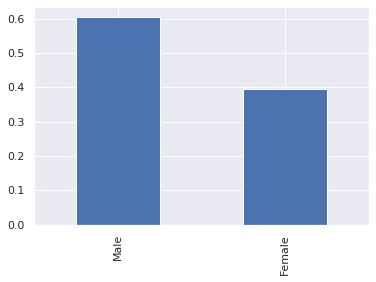

In [8]:
# plot the bar graph customer gender
df['SEX'].value_counts(normalize=True).plot.bar()
plt.xticks([0,1], ['Male', 'Female'])

As seen in the chart, there is an imbalance in the gender ratio

([<matplotlib.axis.XTick at 0x7f14063b2210>,
 <a list of 2 Text xticklabel objects>)

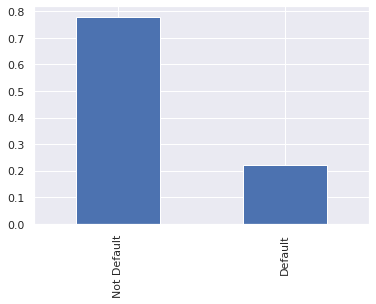

In [9]:
df['default payment next month'].value_counts(normalize=True).plot.bar()
plt.xticks([0,1], ['Not Default', 'Default'])

Majority of clients didn't default on their payment

Text(0.5, 0, 'Clients Age Distribution')

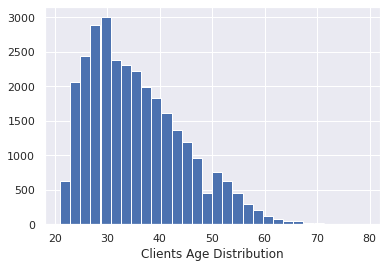

In [10]:
# plot the age distribution
plt.hist(df['AGE'], bins=30)
plt.xlabel('Clients Age Distribution')

We are using the data stored in `s3_raw_data` with data wrangler in the next notebook

# Data Wrangler


Amazon SageMaker Data Wrangler reduces the time it takes to aggregate and prepare data for machine learning (ML). With SageMaker Data Wrangler, you can simplify the process of data preparation and feature engineering, and complete each step of the data preparation workflow, including data selection, cleansing, exploration, and visualization from a single visual interface.

 
<span style="color:red">**TODO:  ADD DATAWRANGLER SCREENSHOTS + Bias**</span>

 
<span style="color:red">**TODO:  IAM Policies required for the demo including [feature store] and lake formation access to feature store (https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-adding-policies.html)**</span>


### Upload data to S3 for Data Wrangler

In [11]:
local_raw_path = f'{local_data_dir}/dataset.csv'
df.to_csv(local_raw_path, index=False)

response = sagemaker_session.upload_data(local_raw_path,
                                         bucket=default_bucket, 
                                         key_prefix=data_prefix)
print(response)

s3_raw_data = response

%store s3_raw_data
%store local_raw_path

s3://sagemaker-us-east-1-367158743199/sagemaker-tutorial/data/dataset.csv
Stored 's3_raw_data' (str)
Stored 'local_raw_path' (str)
